# Pruebas de segmentación con el Catálogo Morfológico de Nebulosas Planetarias del IAC (SUPERVISADO)
En este documento vamos a probar las técnicas comentadas por Diego Cantorna en el documento de astrogestem (disponible en la carpeta astrosegstem de este mismo repositorio) y vamos a añadir ciertas técnicas y mejoras. Todas las técnicas testeadas en este Jupyter Notebook son de aprendizaje no supervisado.

## 1. Carga del Dataset
Vamos a definir una clase, que tome como base la clase Dataset de Pytorch, para poder cargar todo nuestro conjunto de imágenes de uno o varios canales con su máscara correspondiente.

In [2]:
import os

print("Vamos a cambiar el directorio de trabajo")

# Indicamos la ruta del directorio de trabajo
route = os.getcwd()+ "/TFG/test/PNe_segmentation"
os.chdir(route)

current_directory = os.getcwd()
print(" El directorio actual es:", current_directory)

# Listamos el contenido del directorio
files = os.listdir(current_directory)
print(" Contenido del directorio actual:")
for file in files:
    print("\t",file)
    
# Listamos el contenido del directorio de las máscaras
# masks_directory = route+"TFG\\test\\PNe_segmentation\\masks"
# data_directory = route+"TFG\\test\\PNe_segmentation\\data"
## Ejecución en el CESGA Finisterrae III
masks_directory = route+"/masks"
data_directory = route+"/data"


Vamos a cambiar el directorio de trabajo
 El directorio actual es: /mnt/netapp2/Home_FT2/home/ulc/co/ela/TFG/test/PNe_segmentation
 Contenido del directorio actual:
	 commands.txt
	 data
	 data_files.csv
	 data_files_1c.csv
	 images
	 launch_jupyter.sh
	 masks
	 segmentation_no_supervisada.ipynb
	 segmentation_no_supervisada_2c.ipynb
	 segmentation_no_supervisada_pytorch.ipynb
	 segmentation_supervisada.ipynb


In [6]:
import glob
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import random as rd
import numpy as np
from astropy.io import fits

MinMaxNorm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

class NebulaeDataset(Dataset):
    
    def __init__(self, image_path, mask_path, dataframe, rsize = None, transform = None):
        super().__init__()
        
        self.image_path = image_path  # Ruta a las imágenes
        self.mask_path = mask_path  # Ruta a las máscaras
        
        # Cargar los nombres de las imágenes y máscaras desde el dataframe
        self.data_dict = dataframe.set_index('name').to_dict(orient='index')

        # Filtrar las rutas de archivo según los nombres en el dataframe
        self.img_files = [os.path.join(self.image_path, files['h']) for files in self.data_dict.values()]
        self.mask_files = [os.path.join(self.mask_path, files['mask']) for files in self.data_dict.values()]
        self.names = list(self.data_dict.keys())  # Nombres de las imágenes y máscaras
                
        self.rsize = rsize  # Size to use in default Resize transform
        self.transform = transform

    # Returns both the image and the mask
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        
        image = np.flip(fits.getdata(img_path, memmap=False).astype(np.float32), axis=0)
        mask = plt.imread(mask_path)
        
        # Take only the first channel. CHANGE THIS IF WE ARE GOING TO WORK WITH NUMEROUS CHANNELS
        if len(mask.shape) > 2:
            mask = mask[:,:,0]
        if len(image.shape) > 2:
            image = image[:,:,0]
        
        # Apply the defined transformations to both image and mask
        if self.transform is not None:
            seed = np.random.randint(2147483647) # make a seed with numpy generator 
            rd.seed(seed) # apply this seed to image transforms
            torch.manual_seed(seed)
            if type(self.transform) == tuple:
                image = self.transform[0](image)
            else:
                image = self.transform(image)
            rd.seed(seed) # apply the same seed to mask transforms
            torch.manual_seed(seed) 
            if type(self.transform) == tuple:
                mask = self.transform[1](mask)
            else:
                mask = self.transform(mask)
        else:
            if self.rsize is not None:
                t = transforms.Compose([
                    MinMaxNorm,
                    transforms.ToTensor(),
                    transforms.Resize(self.rsize, interpolation= InterpolationMode.NEAREST)
                    ])
            else:
                t = transforms.Compose([
                    MinMaxNorm,
                    transforms.ToTensor()
                    ])

            image = t(image)
            mask = t(mask)
        
        return image, mask.int()

    def __len__(self):
        return len(self.img_files)
    
    def different_shapes(self):
        shapes = set([tuple(self[i][0].permute(2,1,0).shape) for i in range(len(self))])
        return list(shapes)
    
    def plot(self, index, plot_image = True, plot_mask = False):
        """
        Muestra una imagen y/o máscara aleatoria del lote.
        
        Parámetros:
        index (int): Índice del lote.
        plot_image (bool, opcional): Si es True, muestra la imagen. Por defecto es True.
        plot_mask (bool, opcional): Si es True, muestra la máscara. Por defecto es False.
        """
        image, mask = self[index]
        image = image.permute(1,2,0)
        mask = mask.permute(1,2,0)
        name = self.names[index]
        
        if plot_image:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            fig.suptitle(f"Canales de la nebulosa {name}", fontweight = 'bold', fontsize = 14)
            ax.imshow(image, cmap = "gray")
            ax.set_title(f"Canal H")
            fig.show()
        if plot_mask:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            fig.suptitle(f"Máscara de la nebulosa {name}", fontweight = 'bold', fontsize = 14)
            ax.imshow(mask, cmap = "gray")
            fig.show()
            
    def different_shapes(self):
        shapes = set([tuple(self[i][0].permute(2,1,0).shape) for i in range(len(self))])
        return list(shapes)
    
    def bg_obj_proportions(self):
        proportions = []
        for i in range(len(self)):
            mask = self[i][1].numpy()
            bg = np.sum(mask == 0)
            obj = np.sum(mask == 1)
            proportions.append(obj/(bg+obj))
        return proportions


Ahora deberíamos de ser capaces de poder cargar todas las imágenes, como tensores de PyTorch, de nuestro csv como un Dataset

In [4]:
import pandas as pd
df = pd.read_csv("data_files_1c.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df)

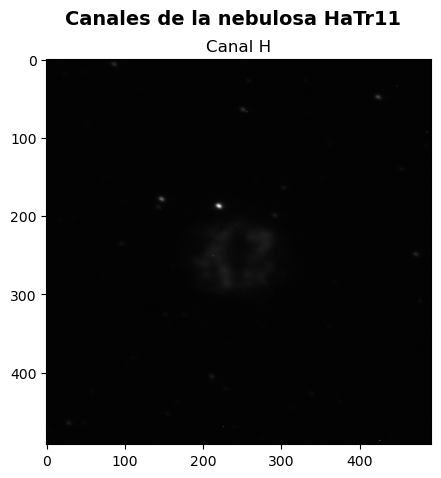

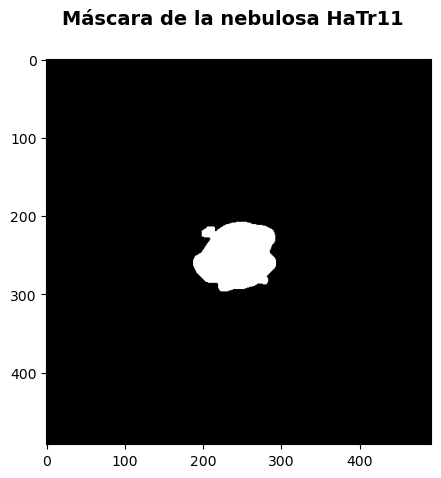

In [5]:
dataset.plot(40, plot_image = True, plot_mask = True)

## 2. Segmentación de las imágenes
Para la segmentación de las imágenes, vamos a probar diferentes algoritmos/técnicas propuestas por Diego Cantorna en el notebook de 'astrosegstem', pero para un mayor conjunto de datos para poder evaluarlas y verificar sus resultados.

### Evaluación de resultados
Para evaluar el resultado de las técnicas de segmentación se pueden emplear distintas métricas.

Algunas de las métricas más utilizadas son la precisión, accuracy y recall, que junto al análisis de la matriz de confusión son las más utilizadas para cualquier problema de procesamiento de imágenes. A estas también se unen:
- **Coeficiente de Dice** (Dice Similarity Coefficient): Mide la similitud entre la segmentación predicha y la segmentación de referencia. Valores más cercanos a 1 indican una mejor superposición. Para un problema de segmentación binaria como el nuestro, el F1-Score y el Dice son equivalentes.
- **Índice de Jaccard** (Jaccard Index o Intersection over Union, IoU): Calcula la intersección entre la segmentación predicha y la segmentación de referencia dividida por su unión. También mide la superposición.
las cuales son métricas básicas y esenciales en los problemas de segmentación.

Vamos a utilizar todas estas métricas para evaluar nuestras técnicas de segmentación.

Vamos a dar mayor prioridad a la hora de evaluar al F1-Score (equivalente al Dice), al IoU y a la precisión, debido a que queremos extraer la silueta aunque no sea de una manera exacta. Métricas como el accuracy en este tipo de problemas no son muy representativas dado a que si el 90 por ciento de la imagen es fondo y nuestra técnica predice como máscara todo 0s (es decir, todo negro) nos va a devolver un 90 por ciento de accuracy pero realmente no nos estaría aportando ninguna información de valor. El recall sería una métrica más idónea si no nos quisiésemos saltar ningún píxel que tenemos que predecir como positivo, aunque diésemos algún falso positivo (métrica muy observada en segmentación de imagen médica por ejemplo). 

### Técnicas de agrupamiento de datos
Las técnicas de agrupamiento (clustering) tratan de encontrar una partición de un
conjunto de datos de forma que los elementos de un mismo grupo sean más similares
que los elementos de grupos distintos. Esto permite resumir un conjunto de datos,
y puede facilitar algunos procesos de visualización o análisis posteriores con otras
técnicas.

In [7]:
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import exposure
from scipy import ndimage


class ApplyKMeans:
    def __init__(self, concat = False, **kwargs):
        self.concat = concat
        self.kwargs = kwargs

    def __call__(self, im):
        im_orig = im.copy()
        if len(im.shape) == 3 and im.shape[2] > 1:
            im = im[:,:,-1]
            
        im_array = im.reshape(-1, 1)
    
        kmeans = KMeans(**self.kwargs).fit(im_array)  # Entrenar el modelo K-Means
        
        # Obtener la imagen segmentada aplicando el algoritmo a cada píxel de la imagen
        im_segm_array = kmeans.predict(im_array)

        # Reemplazar los índices de los clústeres por los centroides de los clústeres
        im_segm_array = np.array([kmeans.cluster_centers_[i] for i in im_segm_array])

        # Cambiar las dimensiones de los datos segmentados para que se correspondan con la imagen inicial
        im_segm = im_segm_array.reshape(im.shape[0], im.shape[1], 1)
        
        if self.concat:
            if len(im_orig.shape) < 3:
                im_orig = np.expand_dims(im_orig, axis=2)
                
            return np.concatenate((im_orig, im_segm), axis=2)
        else:
            return im_segm
        
class ApplyMorphology:
    def __init__(self, operation = morphology.opening, concat = False, **kwargs):
        self.concat = concat
        self.operation = operation
        self.kwargs = kwargs
        if operation == morphology.binary_opening or operation == morphology.binary_closing:
            self.mode = "star_background"
        else:
            self.mode = "nebulae"
    
    def __call__(self, im):
        im_orig = im.copy()
        if len(im.shape) == 3 and im.shape[2] > 1:
            im = im[:,:,-1]
        
        if self.mode == "nebulae":
            im_filt = self.operation(im, **self.kwargs)
        else:
            im_preproc = np.copy(im)
            im_filt = ndimage.gaussian_filter(im, sigma=3)
            im_filt[im == 0] = 0

            im_zonas_claras_peq = im > (im_filt + np.std(im))

            im_zonas_claras_peq = self.operation(im_zonas_claras_peq, **self.kwargs)
                
            im_preproc = (im_preproc - np.min(im_preproc))
            im_preproc[im_zonas_claras_peq] = 0
            
            im_filt = im_preproc
        if self.concat:
            if len(im_orig.shape) < 3:
                im_orig = np.expand_dims(im_orig, axis=2)
                
            im_filt = np.expand_dims(im_filt, axis=2)
            return np.concatenate((im_orig, im_filt), axis=2)
        else:
            return self.operation(im, **self.kwargs)

class ApplyIntensityTransformation:
    def __init__(self, transformation = exposure.rescale_intensity, concat = False, **kwargs):
        self.transformation = transformation
        self.kwargs = kwargs
        self.concat = concat
        self.in_range = None
        self.kernel_size = None
        
        if "in_range" in self.kwargs:
            self.in_range = self.kwargs["in_range"]
        
        if "kernel_size" in self.kwargs:
            self.kernel_size = self.kwargs["kernel_size"]
    
    def __call__(self, im):
        im_orig = im.copy()
        if len(im.shape) == 3 and im.shape[2] > 1:
            im = im[:,:,-1]
        
        if self.in_range is not None:
            self.kwargs["in_range"] = (im.max() * self.in_range[0], im.max() * self.in_range[1])
        
        # self.kwargs["in_range"] = (im.min(), im.max()) # Linea para realizar un reescalado de la intensidad de la imagen lineal
        
        if self.kernel_size is not None:
            self.kwargs["kernel_size"] = im.shape[0] // self.kernel_size
            
        im_trans = self.transformation(im, **self.kwargs)
        if self.concat:
            if len(im_orig.shape) < 3:
                im_orig = np.expand_dims(im_orig, axis=2)
                
            im_trans = np.expand_dims(im_trans, axis=2)
            return np.concatenate((im_orig, im_trans), axis=2)
        else:
            return self.transformation(im, **self.kwargs)
        
class ApplyFilter:
    def __init__(self, filter = ndimage.gaussian_filter, concat = False, **kwargs):
        self.filter = filter
        self.kwargs = kwargs
        self.concat = concat
    
    def __call__(self, im):
        im_orig = im.copy()
        if len(im.shape) == 3 and im.shape[2] > 1:
            im = im[:,:,-1]
        
        im_filt = self.filter(im, **self.kwargs)
        if self.concat:
            if len(im_orig.shape) < 3:
                im_orig = np.expand_dims(im_orig, axis=2)
                
            im_filt = np.expand_dims(im_filt, axis=2)
            return np.concatenate((im_orig, im_filt), axis=2)
        else:
            return self.filter(im, **self.kwargs)
        
class CustomPad():
    def __init__(self, target_size = (1056, 1536), fill = 0):
        self.target_size = target_size
        self.fill = fill
        
    def __call__(self, image):
        # Get the size of the input image
        width, height = image.shape[2], image.shape[1]

        # Compute the size of the padding
        pad_width = self.target_size[1] - width
        pad_height = self.target_size[0] - height

        # Compute the padding
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top

        # Apply the padding
        return transforms.functional.pad(image, (pad_left, pad_top, pad_right, pad_bottom), fill = self.fill)
    
    
def plot_all(image, mask, **kwargs):
        image = image.permute(1,2,0)
        mask = mask.permute(1,2,0)
        
        n_channels = image.shape[2]
        fig, ax = plt.subplots(1, n_channels + 1, figsize=(5 * n_channels, 5))
        # fig.suptitle(f"Canales de la nebulosa y máscara", fontweight = 'bold', fontsize = 14)
        for i in range(n_channels):
            ax[i].imshow(image[:,:,i]*255, **kwargs)
            ax[i].set_title(f"Canal {i}")
            
        ax[n_channels].imshow(mask, cmap = "gray")
        ax[n_channels].set_title(f"Máscara")
        fig.show()
    
def filter_cluster(image, min_background_percentage=0.90):
    """
    Filtra los clusters de una imagen binarizada para obtener el fondo.
    
    Parámetros:
    image (torch.Tensor): Imagen binarizada.
    min_background_percentage (float, opcional): Porcentaje mínimo de píxeles de fondo. Por defecto es 0.90.
    
    Retorna:
    torch.Tensor: Imagen binarizada con el fondo.
    
    """

    # Sort unique cluster values in ascending order
    unique_values = image.unique(sorted=True)

    background = torch.where(image == unique_values[0], torch.tensor(0), torch.tensor(1))

    # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
    for cluster_value in unique_values[1:]:
        
        add_background = torch.where(image == cluster_value, torch.tensor(0), torch.tensor(1))
        new_background = background * add_background
        
        if (1 - new_background.sum() / new_background.numel()) > min_background_percentage:
            break
        
        background = new_background
    
    return background

### 2.1. K-Means
Vamos a comenzar por la técnica más básica (y en la que se basan la mayoría), K-Means.

Para aplicar el algoritmo se selecciona el número de grupos a utilizar y un prototipo (elemento representativo) de cada grupo. A continuación se realiza un proceso iterativo en el que se van asignando datos al grupo más próximo, se recalcula el prototipo de cada grupo, y se repite el proceso hasta que se estabiliza. 

En este caso aplicaremos el algoritmo a los píxeles de imágenes de niveles de gris, por lo que el prototipo de cada grupo será el valor de un píxel. El número de grupos podemos establecerlo manualmente, realizando pruebas con distintos valores. Existen algoritmos más complejos que tratan de automatizar el proceso, pero es interesante familiarizarse inicialmente con las versiones más simples de los algoritmos, para centrar el estudio en los aspectos fundamentales.


Las pruebas con el K-Means van a ser realizadas con un modelo K-Means para cada imagen (para ambos canales) normalizando los datos entre 0 y 1 y dejandolos con sus valores reales (Demostrado que funciona exactamente igual, solo se realizará con los datos normalizados para que todas las imágenes se muevan en el mismo rango de valores).

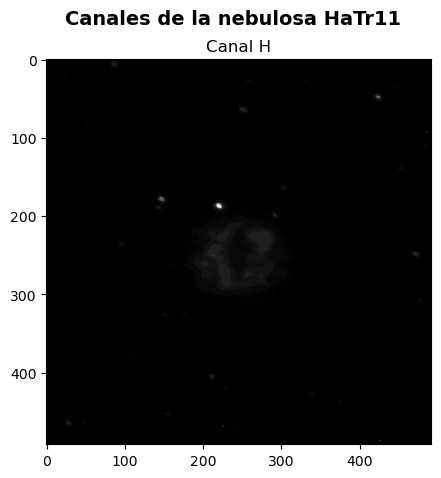

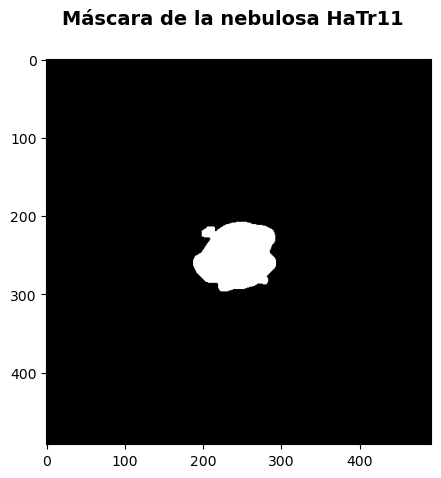

In [8]:
from typing import Any
from sklearn.cluster import KMeans
    
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyKMeans(concat=False, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = 0)
                    ])

# Prueba normalizando los datos entre 0 y 1
df = pd.read_csv("data_files_1c.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

dataset.plot(40, plot_image = True, plot_mask = True)

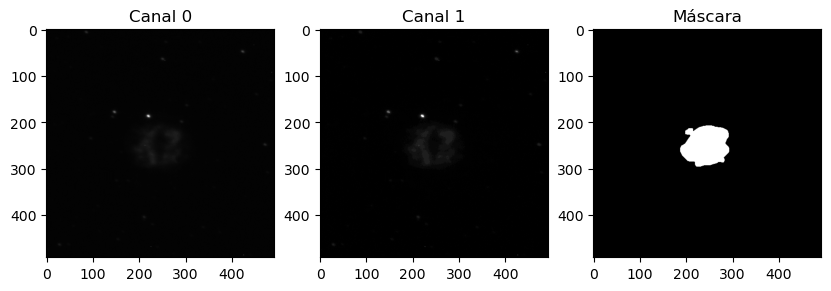

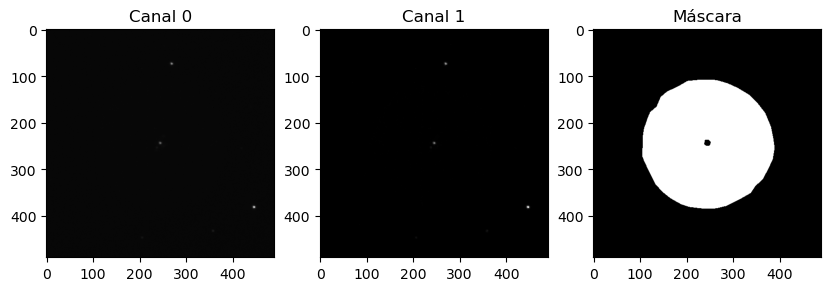

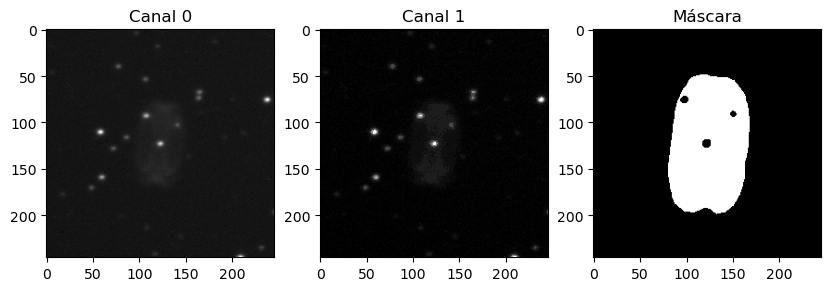

In [9]:
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyKMeans(concat=True, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = 0)
                    ])

# Prueba normalizando los datos entre 0 y 1
df = pd.read_csv("data_files_1c.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

rd.seed(42)
random_indexs = rd.sample(range(len(dataset)), 3)
for index in random_indexs:
    plot_all(*dataset[index], cmap = "gray")

Vamos a realizar un filtrado de los cluster de la siguiente manera:
1. Tomamos el cluster con el valor de centroide más bajo y lo tomamos como fondo
    1. Si el cluster considerado como fondo es demasiado pequeño, nos fijamos en el siguiente cluster con el centroide más bajo
    2. Si el siguiente cluster con los valores de centroide más bajo es muy pequeño nos fijamos en el para considerarlo también como fondo. (Esta parte finalmente no le veo mucho sentido implementarlo, debido a que es practicamente lo mismo que variar el umbral general)
2. El resto que no se ha considerado como fondo se considera como nebulosa consiguiendo una primera aproximación a la segmentación

In [10]:
# Celda para observar las proporciones de fondo máximas, mínimas y medias de las imágenes para decidir el umbral de segmentación
nebulae_proportions = dataset.bg_obj_proportions()
print(f"Mean background proportion: {1-np.mean(nebulae_proportions):.4f}\nMax background proportion: {1-min(nebulae_proportions):.4f}\nMin background proportion: {1-max(nebulae_proportions):.4f}")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/netapp2/Home_FT2/home/ulc/co/ela/TFG/test/PNe_segmentation/masks/H3_29_contour.png'

In [ ]:
# Celda de código donde se realizan algunas pruebas para comprobar los resultados de la segmentación
# Más adelante se implementa este código en una función que se puede llamar desde el script principal

for i in range(0,5):
    image_original, mask = dataset[i]
    image = image_original[1]
    
    min_background_percentage = 0.925
    # min_add_background_percentage = 0.2

    # Sort unique cluster values in ascending order
    unique_values = image.unique(sorted=True)

    background = torch.where(image == unique_values[0], torch.tensor(0), torch.tensor(1))

    fig, ax = plt.subplots(2, (len(unique_values)-1)//2 + (len(unique_values)-1)%2, figsize=(5 * (len(unique_values)-1)//2, 5 * 2))
    cnt = 0
    solution = False
    
    # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
    for cluster_value in unique_values[1:]:
        j, i = divmod(cnt, 2)
        ax[i, j].set_title(f"Background percentage: {(1 - background.sum() / background.numel())*100:.2f}%", fontsize = 9)
        ax[i, j].imshow(background, cmap = "gray")
        fig.show()
        
        add_background = torch.where(image == cluster_value, torch.tensor(0), torch.tensor(1))
        new_background = background * add_background
        
        if (1 - new_background.sum() / new_background.numel()) > min_background_percentage and not solution:
            final_background = background.clone()
            solution = True
        #     if add_background.sum() / add_background.numel() > min_add_background_percentage:
        #         break
        #     else:
        #         continue

        background = new_background
        
        cnt += 1
    
    plt.figure()
    plt.imshow(final_background, cmap = "gray")
    plt.title(f"Segmentation")
    plt.show()
    
    plot_all(image_original, mask, cmap = "gray")

In [ ]:
# def filter_cluster(image, min_background_percentage=0.90):
#     """
#     Filtra los clusters de una imagen binarizada para obtener el fondo.
    
#     Parámetros:
#     image (torch.Tensor): Imagen binarizada.
#     min_background_percentage (float, opcional): Porcentaje mínimo de píxeles de fondo. Por defecto es 0.90.
    
#     Retorna:
#     torch.Tensor: Imagen binarizada con el fondo.
    
#     """

#     # Sort unique cluster values in ascending order
#     unique_values = image.unique(sorted=True)

#     background = torch.where(image == unique_values[0], torch.tensor(0), torch.tensor(1))

#     # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
#     for cluster_value in unique_values[1:]:
        
#         add_background = torch.where(image == cluster_value, torch.tensor(0), torch.tensor(1))
#         new_background = background * add_background
        
#         if (1 - new_background.sum() / new_background.numel()) > min_background_percentage:
#             break
        
#         background = new_background
    
#     return background

Ahora que tenemos una función definida que nos selecciona los primeros clusters convenientes como fondo, vamos a definir una metodología de evaluación y vamos a comprobar que tal funciona nuestra primera aproximación

In [ ]:
import segmentation_models_pytorch as smp
import pandas as pd

results = {"iou": [], "f1": [], "precision": [], "accuracy": [], "recall": []}

for i in range(len(dataset)):
    image, mask = dataset[i]
    image_knn = image[1]
    
    output = filter_cluster(image_knn, min_background_percentage = 0.93).expand_as(mask)
    
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask, mode='binary')
    
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")        # Índice de Jaccard
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")          # F1-Score
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")          # Accuracy
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")    # Sensibilidad
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")        # Precisión

    results["iou"].append(iou_score)
    results["f1"].append(f1_score)
    results["precision"].append(precision)
    results["accuracy"].append(accuracy)
    results["recall"].append(recall)
    
    # plot_all(image, mask, cmap = "gray")
    # plt.figure()
    # plt.imshow(output[0], cmap = "gray")
    # plt.title(f"Segmentation")
    # plt.show()
    # if i == 5:
    #     break 

df = pd.DataFrame(results)
print(df.astype(float).describe().loc[['mean', 'std']].transpose().to_markdown())


***Resultados de K-Means***
|           |     mean |      std |
|:----------|---------:|---------:|
| iou       | 0.301938 | 0.21419  |
| f1        | 0.42291  | 0.256297 |
| precision | 0.505177 | 0.333949 |
| accuracy  | 0.844327 | 0.128148 |
| recall    | 0.587245 | 0.329879 |

(NOTA: A medida que aumento el número de clusters, a 9, 11, 13 y 15, obtengo mejores resultados, puede tener algún inconveniente?)

Vamos a aplicar ciertas mejoras como por ejemplo, aplicar operadores morfológicos para tratar de eliminar las estrellas que acaparan demasiada atención de la técnica de agrupamiento de datos, aplicar algún filtro sencillo con el que consigamos una mejor diferenciación entre los clústeres e intentar aplicar alguna técnica de umbralización con la que se escoja de mejor manera el mejor conjunto de clusters para segmentar la nebulosa.

#### 2.1.1. AREA OPENING

In [ ]:
import skimage.morphology as morphology

df = pd.read_csv("data_files_1c.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df)

imagen = dataset[40][0]
plt.imshow(imagen.permute(1,2,0).numpy(), cmap='gray')

imagen_opening = morphology.area_opening(imagen.permute(1,2,0)[:,:,0].numpy(), area_threshold=500)
# imagen_opening = morphology.remove_small_objects(imagen.permute(1,2,0)[:,:,0].numpy(), min_size=500)
plt.imshow(imagen_opening, cmap='gray')

In [ ]:
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    ApplyKMeans(concat=True, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = 0)
                    ])

df = pd.read_csv("data_files_1c.csv")
# Prueba normalizando los datos entre 0 y 1
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

# def plot_all(image, mask, **kwargs):
#         image = image.permute(1,2,0)
#         mask = mask.permute(1,2,0)
        
#         n_channels = image.shape[2]
#         fig, ax = plt.subplots(1, n_channels + 1, figsize=(5 * n_channels, 5))
#         # fig.suptitle(f"Canales de la nebulosa y máscara", fontweight = 'bold', fontsize = 14)
#         for i in range(n_channels):
#             ax[i].imshow(image[:,:,i]*255, **kwargs)
#             ax[i].set_title(f"Canal {i}")
            
#         ax[n_channels].imshow(mask, cmap = "gray")
#         ax[n_channels].set_title(f"Máscara")
#         fig.show()

rd.seed(42)
random_indexs = rd.sample(range(len(dataset)), 3)
for index in random_indexs:
    plot_all(*dataset[index], cmap = "gray")

In [ ]:
for i in range(0,5):
    image_original, mask = dataset[i]
    image = image_original[-1]
    
    min_background_percentage = 0.93
    # min_add_background_percentage = 0.2

    # Sort unique cluster values in ascending order
    unique_values = image.unique(sorted=True)

    background = torch.where(image == unique_values[0], torch.tensor(0), torch.tensor(1))

    fig, ax = plt.subplots(2, (len(unique_values)-1)//2 + (len(unique_values)-1)%2, figsize=(5 * (len(unique_values)-1)//2, 5 * 2))
    cnt = 0
    solution = False
    
    # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
    for cluster_value in unique_values[1:]:
        j, i = divmod(cnt, 2)
        ax[i, j].set_title(f"Background percentage: {(1 - background.sum() / background.numel())*100:.2f}%", fontsize = 9)
        ax[i, j].imshow(background, cmap = "gray")
        fig.show()
        
        add_background = torch.where(image == cluster_value, torch.tensor(0), torch.tensor(1))
        new_background = background * add_background
        
        if (1 - new_background.sum() / new_background.numel()) > min_background_percentage and not solution:
            final_background = background.clone()
            solution = True
        #     if add_background.sum() / add_background.numel() > min_add_background_percentage:
        #         break
        #     else:
        #         continue

        background = new_background
        
        cnt += 1
    
    plt.figure()
    plt.imshow(final_background, cmap = "gray")
    plt.title(f"Segmentation")
    plt.show()
    
    plot_all(image_original, mask, cmap = "gray")

In [ ]:
import segmentation_models_pytorch as smp
import pandas as pd

results = {"iou": [], "f1": [], "precision": [], "accuracy": [], "recall": []}

for i in range(len(dataset)):
    image, mask = dataset[i]
    image_knn = image[-1]
    
    output = filter_cluster(image_knn, min_background_percentage = 0.93).expand_as(mask)
    # output = morphology.binary_closing(output.permute(1,2,0).numpy()[:,:,0], footprint=morphology.disk(5))
    # output = morphology.remove_small_objects(output, min_size=500)
    # output = torch.tensor(output).unsqueeze(0)
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask, mode='binary')
    
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")        # Índice de Jaccard
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")          # F1-Score
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")          # Accuracy
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")    # Sensibilidad
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")        # Precisión

    results["iou"].append(iou_score)
    results["f1"].append(f1_score)
    results["precision"].append(precision)
    results["accuracy"].append(accuracy)
    results["recall"].append(recall)
    
    # plot_all(image, mask, cmap = "gray")
    # plt.figure()
    # plt.imshow(output[0], cmap = "gray")
    # plt.title(f"Segmentation")
    # plt.show()
    # if i == 5:
    #     break 


df = pd.DataFrame(results)
print(df.astype(float).describe().loc[['mean', 'std']].transpose().to_markdown())

***Resultados de KMeans con operadores morfológicos (opening en área)***
|           |     mean |      std |
|:----------|---------:|---------:|
| iou       | 0.474498 | 0.251984 |
| f1        | 0.600424 | 0.260653 |
| precision | 0.661401 | 0.323928 |
| accuracy  | 0.865881 | 0.162479 |
| recall    | 0.758522 | 0.246124 |

Como se puede observar, se consiguen mejores resultados aplicando operadores morfológicos que sin ellos.
Parece ser que visualmente al procesar la imagen de la última manera que hemos hecho se concentran los valores de los píxeles en ciertos valores, por lo que vamos a imprimir el histograma de algunas imágenes para ver si esto es cierto y vamos a comprobar que no influya demasiado a la hora de realizar el KMeans.

In [ ]:
# PARA EJECUTAR ESTA CELDA CORRECTAMENTE HACE FALTA HABER EJECUTADO EL EXPERIMENTO ANTERIOR
for i in range(0, 5):
    im_op_morf = dataset[i][0].permute(1,2,0).numpy()[:,:,1]
    fig, axis = plt.subplots(1,2, figsize = (8,8))
    axis[0].imshow(im_op_morf, cmap='gray')
    axis[0].set_title("Imagen (op. morf.)")
    axis[1].hist(im_op_morf)
    axis[1].set_title("Histograma de la imagen (op. morf.)")
    fig.suptitle(f"Imagen {i}", fontsize=16, fontweight = 'bold')
    fig.show()
    

In [ ]:
from skimage import exposure
for i in range(0, 5):
    im_op_morf = dataset[i][0].permute(1,2,0).numpy()[:,:,1]
    # Se podría hacer un reescalado de la intensidad de las imagenes del mínimo al máximo (lineal, simplemente mover el histograma)
    # pero haciendo de esta forma conseguimos resaltar las partes de nebulosa respecto de las de fondo
    image_reescaled = exposure.rescale_intensity(im_op_morf, in_range = (im_op_morf.max()/5, im_op_morf.max()), out_range = (0, 1))
    
    # Probamos con un ajuste logarítmico de la intensidad
    # image_reescaled = exposure.adjust_log(im_op_morf, gain=1.2, inv=True)
    
    # También probamos con una ecualización del histograma para que las intensidades estén más repartidas
    # image_reescaled = exposure.equalize_hist(im_op_morf)
    
    # Y por último, probamos con una ecualización adaptativa del histograma
    # image_reescaled = exposure.equalize_adapthist(im_op_morf, kernel_size = im_op_morf.shape[0]//10)
    
    fig, axis = plt.subplots(1,2, figsize = (8,8))
    axis[0].imshow(image_reescaled, cmap='gray')
    axis[0].set_title("Imagen (op. morf.)")
    axis[1].hist(image_reescaled)
    axis[1].set_title("Histograma de la imagen (op. morf.)")
    fig.suptitle(f"Imagen {i}", fontsize=16, fontweight = 'bold')
    fig.show()

In [ ]:
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    # ApplyIntensityTransformation(transformation = exposure.rescale_intensity, concat = True, in_range = (1/5, 1), out_range = (0, 1)),
                    # ApplyIntensityTransformation(transformation = exposure.equalize_adapthist, concat = True, kernel_size = 5),
                    ApplyIntensityTransformation(transformation = exposure.adjust_log, concat = True, gain = 1.5, inv = True),
                    ApplyKMeans(concat=True, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = 0)
                    ])

df = pd.read_csv("data_files_1c.csv")
# Prueba normalizando los datos entre 0 y 1
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

# def plot_all(image, mask, **kwargs):
#         image = image.permute(1,2,0)
#         mask = mask.permute(1,2,0)
        
#         n_channels = image.shape[2]
#         fig, ax = plt.subplots(1, n_channels + 1, figsize=(5 * n_channels, 5))
#         # fig.suptitle(f"Canales de la nebulosa y máscara", fontweight = 'bold', fontsize = 14)
#         for i in range(n_channels):
#             ax[i].imshow(image[:,:,i]*255, **kwargs)
#             ax[i].set_title(f"Canal {i}")
            
#         ax[n_channels].imshow(mask, cmap = "gray")
#         ax[n_channels].set_title(f"Máscara")
#         fig.show()

rd.seed(42)
random_indexs = rd.sample(range(len(dataset)), 3)
for index in random_indexs:
    plot_all(*dataset[index], cmap = "gray")

In [ ]:
for i in range(0,5):
    image_original, mask = dataset[i]
    image = image_original[-1]
    
    min_background_percentage = 0.93
    # min_add_background_percentage = 0.2

    # Sort unique cluster values in ascending order
    unique_values = image.unique(sorted=True)

    background = torch.where(image == unique_values[0], torch.tensor(0), torch.tensor(1))

    fig, ax = plt.subplots(2, (len(unique_values)-1)//2 + (len(unique_values)-1)%2, figsize=(5 * (len(unique_values)-1)//2, 5 * 2))
    cnt = 0
    solution = False
    
    # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
    for cluster_value in unique_values[1:]:
        j, i = divmod(cnt, 2)
        ax[i, j].set_title(f"Background percentage: {(1 - background.sum() / background.numel())*100:.2f}%", fontsize = 9)
        ax[i, j].imshow(background, cmap = "gray")
        fig.show()
        
        add_background = torch.where(image == cluster_value, torch.tensor(0), torch.tensor(1))
        new_background = background * add_background
        
        if (1 - new_background.sum() / new_background.numel()) > min_background_percentage and not solution:
            final_background = background.clone()
            solution = True
        #     if add_background.sum() / add_background.numel() > min_add_background_percentage:
        #         break
        #     else:
        #         continue

        background = new_background
        
        cnt += 1
    
    plt.figure()
    plt.imshow(final_background, cmap = "gray")
    plt.title(f"Segmentation")
    plt.show()
    
    plot_all(image_original, mask, cmap = "gray")

In [ ]:
import segmentation_models_pytorch as smp
import pandas as pd

results = {"iou": [], "f1": [], "precision": [], "accuracy": [], "recall": []}

for i in range(len(dataset)):
    image, mask = dataset[i]
    image_knn = image[-1]
    
    output = filter_cluster(image_knn, min_background_percentage = 0.93).expand_as(mask)
    
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask, mode='binary')
    
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")        # Índice de Jaccard
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")          # F1-Score
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")          # Accuracy
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")    # Sensibilidad
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")        # Precisión

    results["iou"].append(iou_score)
    results["f1"].append(f1_score)
    results["precision"].append(precision)
    results["accuracy"].append(accuracy)
    results["recall"].append(recall)
    
    # plot_all(image, mask, cmap = "gray")
    # plt.figure()
    # plt.imshow(output[0], cmap = "gray")
    # plt.title(f"Segmentation")
    # plt.show()
    # if i == 5:
    #     break 

df = pd.DataFrame(results)
print(df.astype(float).describe().loc[['mean', 'std']].transpose().to_markdown())

***Resultados de KMeans con operadores morfológicos (opening en área) y adaptación del histograma***
|           |     mean |      std |
|:----------|---------:|---------:|
| iou       | 0.462187 | 0.251906 |
| f1        | 0.588433 | 0.261978 |
| precision | 0.653917 | 0.331209 |
| accuracy  | 0.85844  | 0.166378 |
| recall    | 0.753286 | 0.24564  |

Como se puede observar, los mejores resultados obtenidos son muy similares (iguales si se hace una adaptación del histograma lineal) a los resultados obtenidos sin la adaptación del histograma (después de hacer el operador morfológico), vamos a probar a continuación a hacer una adaptación del histograma a la imagen original y después hacer los operadores morfológicos y el KMeans.


In [ ]:
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = True, nbins = 640),
                    # ApplyIntensityTransformation(transformation = exposure.equalize_adapthist, concat = True, nbins = 640, kernel_size = 7),
                    ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    ApplyKMeans(concat=True, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = 0)
                    ])

df = pd.read_csv("data_files_1c.csv")
# Prueba normalizando los datos entre 0 y 1
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

# def plot_all(image, mask, **kwargs):
#         image = image.permute(1,2,0)
#         mask = mask.permute(1,2,0)
        
#         n_channels = image.shape[2]
#         fig, ax = plt.subplots(1, n_channels + 1, figsize=(5 * n_channels, 5))
#         # fig.suptitle(f"Canales de la nebulosa y máscara", fontweight = 'bold', fontsize = 14)
#         for i in range(n_channels):
#             ax[i].imshow(image[:,:,i]*255, **kwargs)
#             ax[i].set_title(f"Canal {i}")
            
#         ax[n_channels].imshow(mask, cmap = "gray")
#         ax[n_channels].set_title(f"Máscara")
#         fig.show()

rd.seed(42)
random_indexs = rd.sample(range(len(dataset)), 3)
for index in random_indexs:
    plot_all(*dataset[index], cmap = "gray")

In [ ]:
for i in range(0,5):
    image_original, mask = dataset[i]
    image = image_original[-1]
    
    min_background_percentage = 0.93
    # min_add_background_percentage = 0.2

    # Sort unique cluster values in ascending order
    unique_values = image.unique(sorted=True)

    background = torch.where(image == unique_values[0], torch.tensor(0), torch.tensor(1))

    fig, ax = plt.subplots(2, (len(unique_values)-1)//2 + (len(unique_values)-1)%2, figsize=(5 * (len(unique_values)-1)//2, 5 * 2))
    cnt = 0
    solution = False
    
    # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
    for cluster_value in unique_values[1:]:
        j, i = divmod(cnt, 2)
        ax[i, j].set_title(f"Background percentage: {(1 - background.sum() / background.numel())*100:.2f}%", fontsize = 9)
        ax[i, j].imshow(background, cmap = "gray")
        fig.show()
        
        add_background = torch.where(image == cluster_value, torch.tensor(0), torch.tensor(1))
        new_background = background * add_background
        
        if (1 - new_background.sum() / new_background.numel()) > min_background_percentage and not solution:
            final_background = background.clone()
            solution = True
        #     if add_background.sum() / add_background.numel() > min_add_background_percentage:
        #         break
        #     else:
        #         continue

        background = new_background
        
        cnt += 1
    
    # final_background = morphology.binary_closing(final_background, footprint=morphology.disk(5))
    # final_background = morphology.remove_small_objects(final_background, min_size=500)
    
    plt.figure()
    plt.imshow(final_background, cmap = "gray")
    plt.title(f"Segmentation")
    plt.show()
    
    plot_all(image_original, mask, cmap = "gray")

In [ ]:
import segmentation_models_pytorch as smp
import pandas as pd

results = {"iou": [], "f1": [], "precision": [], "accuracy": [], "recall": []}

for i in range(len(dataset)):
    image, mask = dataset[i]
    image_knn = image[-1]
    
    output = filter_cluster(image_knn, min_background_percentage = 0.93).expand_as(mask)
    # output = morphology.binary_closing(output.permute(1,2,0).numpy()[:,:,0], footprint=morphology.disk(5))
    # output = morphology.remove_small_objects(output, min_size=500)
    # output = torch.tensor(output).unsqueeze(0)
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask, mode='binary')
    
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")        # Índice de Jaccard
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")          # F1-Score
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")          # Accuracy
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")    # Sensibilidad
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")        # Precisión

    results["iou"].append(iou_score)
    results["f1"].append(f1_score)
    results["precision"].append(precision)
    results["accuracy"].append(accuracy)
    results["recall"].append(recall)
    
    # plot_all(image, mask, cmap = "gray")
    # plt.figure()
    # plt.imshow(output[0], cmap = "gray")
    # plt.title(f"Segmentation")
    # plt.show()
    # if i == 5:
    #     break 

df = pd.DataFrame(results)
print(df.astype(float).describe().loc[['mean', 'std']].transpose().to_markdown())

***Resultados de KMeans con adaptación del histograma y operadores morfológicos (opening en área)***
|           |     mean |       std |
|:----------|---------:|----------:|
| iou       | 0.482382 | 0.243033  |
| f1        | 0.610257 | 0.255888  |
| precision | 0.646103 | 0.303263  |
| accuracy  | 0.911641 | 0.0766837 |
| recall    | 0.747889 | 0.289217  |

Como podemos observar, los resultados practicamente iguales que los anteriores aunque, al ver las imágenes me hace sospechar que un filtro como por ejemplo Gaussiano después de la adaptación del histograma podría hacer mejorar los resultados considerablemente. Otra mejora que veo posible es la de incluir el operador morfológico de closing en el resultado final como postprocesado, aunque de este apartado podemos hablar más adelante (dejamos los resultados en la siguiente tabla haciendo una pequeña prueba con esta mejora)

|           |     mean |      std |
|:----------|---------:|---------:|
| iou       | 0.514091 | 0.257969 |
| f1        | 0.635843 | 0.262296 |
| precision | 0.654544 | 0.309503 |
| accuracy  | 0.903982 | 0.104944 |
| recall    | 0.814793 | 0.249345 |

Como última prueba de este apartado vamos a probar a eliminar por completo gracias a los operadores morfológicos el fondo de estrellas de las imágenes, en vez de intentar reducir su visibilidad en vez de ignorarlas como estabamos haciendo hasta ahora (gracias a la función area_opening). 

#### 2.1.2. BINARY OPENING

In [ ]:
import skimage.morphology as morphology
from scipy import ndimage

df = pd.read_csv("data_files_1c.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df)

fig, ax = plt.subplots(1,2, figsize = (8,8))
imagen = dataset[1][0].permute(1,2,0).numpy()[:,:,0]
imagen_preproc = np.copy(imagen)

ax[0].imshow(imagen, cmap='gray')

imagen_filt = ndimage.gaussian_filter(imagen, sigma=3)
imagen_filt[imagen == 0] = 0

imagen_zonas_claras_peq = imagen > (imagen_filt + np.std(imagen))

imagen_zonas_claras_peq = morphology.binary_opening(imagen_zonas_claras_peq, morphology.disk(2))
    
imagen_preproc = (imagen_preproc - np.min(imagen_preproc))
imagen_preproc[imagen_zonas_claras_peq] = 0

# imagen_opening = morphology.remove_small_objects(imagen.permute(1,2,0)[:,:,0].numpy(), min_size=500)
ax[1].imshow(imagen_preproc, cmap='gray')

In [ ]:
# class ApplyMorphology:
#     def __init__(self, operation = morphology.opening, concat = False, **kwargs):
#         self.concat = concat
#         self.operation = operation
#         self.kwargs = kwargs
#         if operation == morphology.binary_opening or operation == morphology.binary_closing:
#             self.mode = "star_background"
#         else:
#             self.mode = "nebulae"
    
#     def __call__(self, im):
#         im_orig = im.copy()
#         if len(im.shape) == 3 and im.shape[2] > 1:
#             im = im[:,:,-1]
        
#         if self.mode == "nebulae":
#             im_filt = self.operation(im, **self.kwargs)
#         else:
#             im_preproc = np.copy(im)
#             im_filt = ndimage.gaussian_filter(im, sigma=3)
#             im_filt[im == 0] = 0

#             im_zonas_claras_peq = im > (im_filt + np.std(im))

#             im_zonas_claras_peq = self.operation(im_zonas_claras_peq, **self.kwargs)
                
#             im_preproc = (im_preproc - np.min(im_preproc))
#             im_preproc[im_zonas_claras_peq] = 0
            
#             im_filt = im_preproc
#         if self.concat:
#             if len(im_orig.shape) < 3:
#                 im_orig = np.expand_dims(im_orig, axis=2)
                
#             im_filt = np.expand_dims(im_filt, axis=2)
#             return np.concatenate((im_orig, im_filt), axis=2)
#         else:
#             return self.operation(im, **self.kwargs)
        
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyMorphology(operation = morphology.binary_opening, concat = True, footprint = morphology.disk(2)),
                    ApplyKMeans(concat=True, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = 0)
                    ])

df = pd.read_csv("data_files_1c.csv")
# Prueba normalizando los datos entre 0 y 1
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

# def plot_all(image, mask, **kwargs):
#         image = image.permute(1,2,0)
#         mask = mask.permute(1,2,0)
        
#         n_channels = image.shape[2]
#         fig, ax = plt.subplots(1, n_channels + 1, figsize=(5 * n_channels, 5))
#         # fig.suptitle(f"Canales de la nebulosa y máscara", fontweight = 'bold', fontsize = 14)
#         for i in range(n_channels):
#             ax[i].imshow(image[:,:,i]*255, **kwargs)
#             ax[i].set_title(f"Canal {i}")
            
#         ax[n_channels].imshow(mask, cmap = "gray")
#         ax[n_channels].set_title(f"Máscara")
#         fig.show()

rd.seed(42)
random_indexs = rd.sample(range(len(dataset)), 3)
for index in random_indexs:
    plot_all(*dataset[index], cmap = "gray")

In [ ]:
for i in range(0,5):
    image_original, mask = dataset[i]
    image = image_original[-1]
    
    min_background_percentage = 0.93
    # min_add_background_percentage = 0.2

    # Sort unique cluster values in ascending order
    unique_values = image.unique(sorted=True)

    background = torch.where(image == unique_values[0], torch.tensor(0), torch.tensor(1))

    fig, ax = plt.subplots(2, (len(unique_values)-1)//2 + (len(unique_values)-1)%2, figsize=(5 * (len(unique_values)-1)//2, 5 * 2))
    cnt = 0
    solution = False
    
    # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
    for cluster_value in unique_values[1:]:
        j, i = divmod(cnt, 2)
        ax[i, j].set_title(f"Background percentage: {(1 - background.sum() / background.numel())*100:.2f}%", fontsize = 9)
        ax[i, j].imshow(background, cmap = "gray")
        fig.show()
        
        add_background = torch.where(image == cluster_value, torch.tensor(0), torch.tensor(1))
        new_background = background * add_background
        
        if (1 - new_background.sum() / new_background.numel()) > min_background_percentage and not solution:
            final_background = background.clone()
            solution = True
        #     if add_background.sum() / add_background.numel() > min_add_background_percentage:
        #         break
        #     else:
        #         continue

        background = new_background
        
        cnt += 1
    
    plt.figure()
    plt.imshow(final_background, cmap = "gray")
    plt.title(f"Segmentation")
    plt.show()
    
    plot_all(image_original, mask, cmap = "gray")

In [ ]:
import segmentation_models_pytorch as smp
import pandas as pd

results = {"iou": [], "f1": [], "precision": [], "accuracy": [], "recall": []}

for i in range(len(dataset)):
    image, mask = dataset[i]
    image_knn = image[-1]
    
    output = filter_cluster(image_knn, min_background_percentage = 0.93).expand_as(mask)
    # output = morphology.binary_closing(output.permute(1,2,0).numpy()[:,:,0], footprint=morphology.disk(5))
    # output = morphology.remove_small_objects(output, min_size=500)
    # output = torch.tensor(output).unsqueeze(0)
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask, mode='binary')
    
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")        # Índice de Jaccard
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")          # F1-Score
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")          # Accuracy
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")    # Sensibilidad
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")        # Precisión

    results["iou"].append(iou_score)
    results["f1"].append(f1_score)
    results["precision"].append(precision)
    results["accuracy"].append(accuracy)
    results["recall"].append(recall)
    
    # plot_all(image, mask, cmap = "gray")
    # plt.figure()
    # plt.imshow(output[0], cmap = "gray")
    # plt.title(f"Segmentation")
    # plt.show()
    # if i == 5:
    #     break 


df = pd.DataFrame(results)
print(df.astype(float).describe().loc[['mean', 'std']].transpose().to_markdown())

***Resultados de KMeans con operadores morfólogicos para eliminar el fondo de estrellas (opening binario)***
|           |     mean |      std |
|:----------|---------:|---------:|
| iou       | 0.340304 | 0.202407 |
| f1        | 0.474101 | 0.230723 |
| precision | 0.548508 | 0.328343 |
| accuracy  | 0.860052 | 0.112781 |
| recall    | 0.629009 | 0.295397 |

Como podemos comprobar, funciona algo mejor que solo utilizar KMeans aunque bastante parecido, como se puede observar en las imágenes observadas. Vamos a probar a unificar las dos técnicas de operadores morfológicos que hemos aplicado, primero eliminamos el fondo de estrellas y después intentamos visualizar lo menos posible los restos que queden de el (primero binary_opening y después area_opening)

In [ ]:
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyMorphology(operation = morphology.binary_opening, concat = True, footprint = morphology.disk(2)),
                    ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    ApplyKMeans(concat=True, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = 0)
                    ])

df = pd.read_csv("data_files_1c.csv")
# Prueba normalizando los datos entre 0 y 1
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

# def plot_all(image, mask, **kwargs):
#         image = image.permute(1,2,0)
#         mask = mask.permute(1,2,0)
        
#         n_channels = image.shape[2]
#         fig, ax = plt.subplots(1, n_channels + 1, figsize=(5 * n_channels, 5))
#         # fig.suptitle(f"Canales de la nebulosa y máscara", fontweight = 'bold', fontsize = 14)
#         for i in range(n_channels):
#             ax[i].imshow(image[:,:,i]*255, **kwargs)
#             ax[i].set_title(f"Canal {i}")
            
#         ax[n_channels].imshow(mask, cmap = "gray")
#         ax[n_channels].set_title(f"Máscara")
#         fig.show()

rd.seed(42)
random_indexs = rd.sample(range(len(dataset)), 3)
for index in random_indexs:
    plot_all(*dataset[index], cmap = "gray")

In [ ]:
for i in range(0,5):
    image_original, mask = dataset[i]
    image = image_original[-1]
    
    min_background_percentage = 0.93
    # min_add_background_percentage = 0.2

    # Sort unique cluster values in ascending order
    unique_values = image.unique(sorted=True)

    background = torch.where(image == unique_values[0], torch.tensor(0), torch.tensor(1))

    fig, ax = plt.subplots(2, (len(unique_values)-1)//2 + (len(unique_values)-1)%2, figsize=(5 * (len(unique_values)-1)//2, 5 * 2))
    cnt = 0
    solution = False
    
    # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
    for cluster_value in unique_values[1:]:
        j, i = divmod(cnt, 2)
        ax[i, j].set_title(f"Background percentage: {(1 - background.sum() / background.numel())*100:.2f}%", fontsize = 9)
        ax[i, j].imshow(background, cmap = "gray")
        fig.show()
        
        add_background = torch.where(image == cluster_value, torch.tensor(0), torch.tensor(1))
        new_background = background * add_background
        
        if (1 - new_background.sum() / new_background.numel()) > min_background_percentage and not solution:
            final_background = background.clone()
            solution = True
        #     if add_background.sum() / add_background.numel() > min_add_background_percentage:
        #         break
        #     else:
        #         continue

        background = new_background
        
        cnt += 1
    
    plt.figure()
    plt.imshow(final_background, cmap = "gray")
    plt.title(f"Segmentation")
    plt.show()
    
    plot_all(image_original, mask, cmap = "gray")

In [ ]:
import segmentation_models_pytorch as smp
import pandas as pd

results = {"iou": [], "f1": [], "precision": [], "accuracy": [], "recall": []}

for i in range(len(dataset)):
    image, mask = dataset[i]
    image_knn = image[-1]
    
    output = filter_cluster(image_knn, min_background_percentage = 0.94).expand_as(mask)
    # output = morphology.binary_closing(output.permute(1,2,0).numpy()[:,:,0], footprint=morphology.disk(5))
    # output = morphology.remove_small_objects(output, min_size=500)
    # output = torch.tensor(output).unsqueeze(0)
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask, mode='binary')
    
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")        # Índice de Jaccard
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")          # F1-Score
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")          # Accuracy
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")    # Sensibilidad
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")        # Precisión

    results["iou"].append(iou_score)
    results["f1"].append(f1_score)
    results["precision"].append(precision)
    results["accuracy"].append(accuracy)
    results["recall"].append(recall)
    
    # plot_all(image, mask, cmap = "gray")
    # plt.figure()
    # plt.imshow(output[0], cmap = "gray")
    # plt.title(f"Segmentation")
    # plt.show()
    # if i == 5:
    #     break 


df = pd.DataFrame(results)
print(df.astype(float).describe().loc[['mean', 'std']].transpose().to_markdown())

***Resultados de KMeans con operadores morfológicos (ambas técnicas)***
|           |     mean |      std |
|:----------|---------:|---------:|
| iou       | 0.472936 | 0.234044 |
| f1        | 0.605284 | 0.24067  |
| precision | 0.67945  | 0.311074 |
| accuracy  | 0.878765 | 0.142001 |
| recall    | 0.726142 | 0.241789 |

Como se puede ver los resultados son muy parecidos a solo realizar la técnica de operadores morfológicos que NO elimina el fondo de estrellas por completo, aunque hemos tenido que subir un poco el umbral manual (porcentaje de píxeles de fondo) para obtener ese resultado, por lo que vamos a comprobar los resultados que da con una adaptación del histograma entre ambas técnicas de operadores morfológicos.

In [ ]:
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyMorphology(operation = morphology.binary_opening, concat = True, footprint = morphology.disk(2)),
                    ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = True, nbins = 640),
                    # ApplyIntensityTransformation(transformation = exposure.equalize_adapthist, concat = True, nbins = 640, kernel_size = 7),
                    ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    ApplyKMeans(concat=True, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = 0)
                    ])

df = pd.read_csv("data_files_1c.csv")
# Prueba normalizando los datos entre 0 y 1
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

# def plot_all(image, mask, **kwargs):
#         image = image.permute(1,2,0)
#         mask = mask.permute(1,2,0)
        
#         n_channels = image.shape[2]
#         fig, ax = plt.subplots(1, n_channels + 1, figsize=(5 * n_channels, 5))
#         # fig.suptitle(f"Canales de la nebulosa y máscara", fontweight = 'bold', fontsize = 14)
#         for i in range(n_channels):
#             ax[i].imshow(image[:,:,i]*255, **kwargs)
#             ax[i].set_title(f"Canal {i}")
            
#         ax[n_channels].imshow(mask, cmap = "gray")
#         ax[n_channels].set_title(f"Máscara")
#         fig.show()

rd.seed(42)
random_indexs = rd.sample(range(len(dataset)), 3)
for index in random_indexs:
    plot_all(*dataset[index], cmap = "gray")

In [ ]:
for i in range(0,5):
    image_original, mask = dataset[i]
    image = image_original[-1]
    
    min_background_percentage = 0.93
    # min_add_background_percentage = 0.2

    # Sort unique cluster values in ascending order
    unique_values = image.unique(sorted=True)

    background = torch.where(image == unique_values[0], torch.tensor(0), torch.tensor(1))

    fig, ax = plt.subplots(2, (len(unique_values)-1)//2 + (len(unique_values)-1)%2, figsize=(5 * (len(unique_values)-1)//2, 5 * 2))
    cnt = 0
    solution = False
    
    # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
    for cluster_value in unique_values[1:]:
        j, i = divmod(cnt, 2)
        ax[i, j].set_title(f"Background percentage: {(1 - background.sum() / background.numel())*100:.2f}%", fontsize = 9)
        ax[i, j].imshow(background, cmap = "gray")
        fig.show()
        
        add_background = torch.where(image == cluster_value, torch.tensor(0), torch.tensor(1))
        new_background = background * add_background
        
        if (1 - new_background.sum() / new_background.numel()) > min_background_percentage and not solution:
            final_background = background.clone()
            solution = True
        #     if add_background.sum() / add_background.numel() > min_add_background_percentage:
        #         break
        #     else:
        #         continue

        background = new_background
        
        cnt += 1
    
    # final_background = morphology.binary_closing(final_background, footprint=morphology.disk(5))
    # final_background = morphology.remove_small_objects(final_background, min_size=500)
    
    plt.figure()
    plt.imshow(final_background, cmap = "gray")
    plt.title(f"Segmentation")
    plt.show()
    
    plot_all(image_original, mask, cmap = "gray")

In [ ]:
import segmentation_models_pytorch as smp
import pandas as pd

results = {"iou": [], "f1": [], "precision": [], "accuracy": [], "recall": []}

for i in range(len(dataset)):
    image, mask = dataset[i]
    image_knn = image[-1]
    
    output = filter_cluster(image_knn, min_background_percentage = 0.94).expand_as(mask)
    output = morphology.binary_closing(output.permute(1,2,0).numpy()[:,:,0], footprint=morphology.disk(5))
    output = morphology.remove_small_objects(output, min_size=500)
    output = torch.tensor(output).unsqueeze(0)
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask, mode='binary')
    
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")        # Índice de Jaccard
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")          # F1-Score
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")          # Accuracy
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")    # Sensibilidad
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")        # Precisión

    results["iou"].append(iou_score)
    results["f1"].append(f1_score)
    results["precision"].append(precision)
    results["accuracy"].append(accuracy)
    results["recall"].append(recall)
    
    # plot_all(image, mask, cmap = "gray")
    # plt.figure()
    # plt.imshow(output[0], cmap = "gray")
    # plt.title(f"Segmentation")
    # plt.show()
    # if i == 5:
    #     break 

df = pd.DataFrame(results)
print(df.astype(float).describe().loc[['mean', 'std']].transpose().to_markdown())

***Resultados de KMeans con Opening binario, adaptación del histograma y opening en área***
|           |     mean |       std |
|:----------|---------:|----------:|
| iou       | 0.496861 | 0.230796  |
| f1        | 0.62982  | 0.227609  |
| precision | 0.661146 | 0.282945  |
| accuracy  | 0.916543 | 0.0739382 |
| recall    | 0.769579 | 0.246387  |

Vamos a comprobar finalmente que tal funcionaría con el postprocesado sencillo que probamos anteriormente

***Resultados de KMeans con Opening binario, adaptación del histograma y opening en área + postprocesado***
|           |     mean |       std |
|:----------|---------:|----------:|
| iou       | 0.534588 | 0.250919  |
| f1        | 0.658135 | 0.243586  |
| precision | 0.656112 | 0.29426   |
| accuracy  | 0.917111 | 0.0781187 |
| recall    | 0.841828 | 0.223383  |

#### 2.1.3. FILTRO GAUSSIANO

In [ ]:
from skimage import exposure
import scipy.ndimage as ndimage

df = pd.read_csv("data_files_1c.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df)

for i in range(0, 5):
    image = dataset[i][0].permute(1,2,0).numpy()[:,:,0]
    
    # image_reescaled = exposure.equalize_hist(image, nbins = 640)
    
    # im_op_morf = morphology.area_opening(image_reescaled, area_threshold=200)
    
    im_op_morf = morphology.area_opening(image, area_threshold=200)
    
    imagen_filter = ndimage.gaussian_filter(im_op_morf, sigma = 4)
    
    
    # Se podría hacer un reescalado de la intensidad de las imagenes del mínimo al máximo (lineal, simplemente mover el histograma)
    # pero haciendo de esta forma conseguimos resaltar las partes de nebulosa respecto de las de fondo
    # image_reescaled = exposure.rescale_intensity(im_op_morf, in_range = (im_op_morf.max()/5, im_op_morf.max()), out_range = (0, 1))
    
    # Probamos con un ajuste logarítmico de la intensidad
    # image_reescaled = exposure.adjust_log(im_op_morf, gain=1.2, inv=True)
    
    # También probamos con una ecualización del histograma para que las intensidades estén más repartidas
    # image_reescaled = exposure.equalize_hist(im_op_morf, nbins = 640)
    
    # Y por último, probamos con una ecualización adaptativa del histograma
    # image_reescaled = exposure.equalize_adapthist(im_op_morf, kernel_size = im_op_morf.shape[0]//10)
    
    fig, axis = plt.subplots(1,2, figsize = (8,8))
    axis[0].imshow(imagen_filter, cmap='gray')
    axis[0].set_title("Imagen (op. morf.)")
    axis[1].hist(imagen_filter)
    axis[1].set_title("Histograma de la imagen (op. morf.)")
    fig.suptitle(f"Imagen {i}", fontsize=16, fontweight = 'bold')
    fig.show()

In [ ]:
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyMorphology(operation = morphology.binary_opening, concat = True, footprint = morphology.disk(2)),
                    # ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = True, nbins = 640),
                    # ApplyIntensityTransformation(transformation = exposure.equalize_adapthist, concat = True, nbins = 640, kernel_size = 5),
                    ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    ApplyFilter(filter = ndimage.gaussian_filter, concat = True, sigma = 5),
                    ApplyKMeans(concat=True, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = 0)
                    ])

df = pd.read_csv("data_files_1c.csv")
# Prueba normalizando los datos entre 0 y 1
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

# def plot_all(image, mask, **kwargs):
#         image = image.permute(1,2,0)
#         mask = mask.permute(1,2,0)
        
#         n_channels = image.shape[2]
#         fig, ax = plt.subplots(1, n_channels + 1, figsize=(5 * n_channels, 5))
#         # fig.suptitle(f"Canales de la nebulosa y máscara", fontweight = 'bold', fontsize = 14)
#         for i in range(n_channels):
#             ax[i].imshow(image[:,:,i]*255, **kwargs)
#             ax[i].set_title(f"Canal {i}")
            
#         ax[n_channels].imshow(mask, cmap = "gray")
#         ax[n_channels].set_title(f"Máscara")
#         fig.show()

rd.seed(42)
random_indexs = rd.sample(range(len(dataset)), 3)
for index in random_indexs:
    plot_all(*dataset[index], cmap = "gray")

In [ ]:
for i in range(0,5):
    image_original, mask = dataset[i]
    image = image_original[-1]
    
    min_background_percentage = 0.93
    # min_add_background_percentage = 0.2

    # Sort unique cluster values in ascending order
    unique_values = image.unique(sorted=True)

    background = torch.where(image == unique_values[0], torch.tensor(0), torch.tensor(1))

    fig, ax = plt.subplots(2, (len(unique_values)-1)//2 + (len(unique_values)-1)%2, figsize=(5 * (len(unique_values)-1)//2, 5 * 2))
    cnt = 0
    solution = False
    
    # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
    for cluster_value in unique_values[1:]:
        j, i = divmod(cnt, 2)
        ax[i, j].set_title(f"Background percentage: {(1 - background.sum() / background.numel())*100:.2f}%", fontsize = 9)
        ax[i, j].imshow(background, cmap = "gray")
        fig.show()
        
        add_background = torch.where(image == cluster_value, torch.tensor(0), torch.tensor(1))
        new_background = background * add_background
        
        if (1 - new_background.sum() / new_background.numel()) > min_background_percentage and not solution:
            final_background = background.clone()
            solution = True
        #     if add_background.sum() / add_background.numel() > min_add_background_percentage:
        #         break
        #     else:
        #         continue

        background = new_background
        
        cnt += 1
    
    # final_background = morphology.binary_closing(final_background, footprint=morphology.disk(5))
    # final_background = morphology.remove_small_objects(final_background, min_size=500)
    
    plt.figure()
    plt.imshow(final_background, cmap = "gray")
    plt.title(f"Segmentation")
    plt.show()
    
    plot_all(image_original, mask, cmap = "gray")

In [ ]:
import segmentation_models_pytorch as smp
import pandas as pd

results = {"iou": [], "f1": [], "precision": [], "accuracy": [], "recall": []}

for i in range(len(dataset)):
    image, mask = dataset[i]
    image_knn = image[-1]
    
    output = filter_cluster(image_knn, min_background_percentage = 0.94).expand_as(mask)
    output = output.permute(1,2,0).numpy()[:,:,0]
    output = morphology.binary_closing(output, footprint=morphology.disk(5))
    output = morphology.remove_small_objects(output, min_size=500)
    output = torch.tensor(output).unsqueeze(0)
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask, mode='binary')
    
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")        # Índice de Jaccard
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")          # F1-Score
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")          # Accuracy
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")    # Sensibilidad
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")        # Precisión

    results["iou"].append(iou_score)
    results["f1"].append(f1_score)
    results["precision"].append(precision)
    results["accuracy"].append(accuracy)
    results["recall"].append(recall)
    
    # plot_all(image, mask, cmap = "gray")
    # plt.figure()
    # plt.imshow(output[0], cmap = "gray")
    # plt.title(f"Segmentation")
    # plt.show()
    # if i == 5:
    #     break 

df = pd.DataFrame(results)
print(df.astype(float).describe().loc[['mean', 'std']].transpose().to_markdown())

***Resultados de KMeans con opening en área y Filtro Gaussiano (sigma 5)***
|           |     mean |      std |
|:----------|---------:|---------:|
| iou       | 0.533148 | 0.247184 |
| f1        | 0.65724  | 0.245682 |
| precision | 0.732878 | 0.29252  |
| accuracy  | 0.901664 | 0.115164 |
| recall    | 0.758274 | 0.244278 |

***Resultados de KMeans con adaptación del histograma, opening en área y filtro gaussiano***
|           |     mean |       std |
|:----------|---------:|----------:|
| iou       | 0.51504  | 0.252026  |
| f1        | 0.638368 | 0.258574  |
| precision | 0.694062 | 0.30799   |
| accuracy  | 0.918851 | 0.0819133 |
| recall    | 0.751193 | 0.286227  |

***Resultados de KMeans con opening binario, opening en área y Filtro Gaussiano (sigma 5)***
|           |     mean |      std |
|:----------|---------:|---------:|
| iou       | 0.50307  | 0.227348 |
| f1        | 0.636952 | 0.22226  |
| precision | 0.701959 | 0.301808 |
| accuracy  | 0.903936 | 0.106539 |
| recall    | 0.763739 | 0.249194 |

***Resultados de KMeans con opening binario, adaptación del histograma, opening en área y Filtro Gaussiano (sigma 5)***
|           |     mean |      std |
|:----------|---------:|---------:|
| iou       | 0.537252 | 0.246508 |
| f1        | 0.663492 | 0.228315 |
| precision | 0.719191 | 0.298549 |
| accuracy  | 0.925891 | 0.073396 |
| recall    | 0.776446 | 0.243754 |

***Resultados de KMeans con opening binario, adaptación del histograma, opening en área y Filtro Gaussiano (sigma 5) + postprocesado***
|           |     mean |       std |
|:----------|---------:|----------:|
| iou       | 0.544275 | 0.244476  |
| f1        | 0.670401 | 0.224853  |
| precision | 0.728293 | 0.294329  |
| accuracy  | 0.927701 | 0.0734514 |
| recall    | 0.777289 | 0.24409   |

#### 2.1.4. UMBRALIZACIÓN (para evitar tener que elegir un umbral en el porcentaje de píxeles de fondo)

Necesitamos algún método, como por ejemplo un test estadístico, que nos ayude a que la división de clusters en fondo y nebulosa sea más personalizada para cada imagen de lo que es un umbral de porcentaje de píxeles de fondo.

Algunas ideas que se me han ocurrido han sido:
- Aplicar algún método, como Otsu, donde se considera cada cluster como una clase y se busca la división de los datos (a través de un umbral) que minimize la varianza intra-clase.

- Intentar modelar los clúster como una Mixtura de Gaussianas (GMM, por sus siglas en inglés Gaussian Mixture Model) de dos Gaussianas (o más, pero por simplicidad y para empezar solo con 2)

(NOTA: Aunque utilicemos otros métodos para separar los clústers en fondo y nebulosa, podemos seguir utilizando el umbral del porcentaje manual para descartar los primeros clústeres que van a ser la mayoría de veces solo fondo)


In [ ]:
df = pd.read_csv("data_files_1c.csv")
dataset = NebulaeDataset(data_directory, masks_directory, df)

for i in range(0, 5):
    imagen = dataset[i][0].permute(1,2,0).numpy()[:,:,0]
    imagen = exposure.equalize_hist(imagen, nbins = 1024)
    fig, axis = plt.subplots(1,2, figsize = (8,8))
    axis[0].imshow(imagen, cmap='gray')
    axis[0].set_title("Imagen (op. morf.)")
    axis[1].hist(imagen)
    axis[1].set_title("Histograma de la imagen (op. morf.)")
    fig.suptitle(f"Imagen {i}", fontsize=16, fontweight = 'bold')
    fig.show()
    

##### Método de Otsu (simple)
Vamos a comenzar aplicando al KMeans una umbralización de Otsu, tanto de manera general como local, para comprobar si consigue separar los clusters del KMeans en fondo y nebulosa

In [ ]:
transform_x = transforms.Compose([
                    MinMaxNorm,
                    # ApplyMorphology(operation = morphology.binary_opening, concat = True, footprint = morphology.disk(2)),
                    # ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = True, nbins = 640),
                    # ApplyIntensityTransformation(transformation = exposure.equalize_adapthist, concat = True, nbins = 640, kernel_size = 5),
                    # ApplyMorphology(operation = morphology.area_opening, concat = True, area_threshold = 200, connectivity = 1),
                    # ApplyFilter(filter = ndimage.gaussian_filter, concat = True, sigma = 5),
                    ApplyKMeans(concat=True, n_clusters=7, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = 0)
                    ])

df = pd.read_csv("data_files_1c.csv")
# Prueba normalizando los datos entre 0 y 1
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

rd.seed(42)
random_indexs = rd.sample(range(len(dataset)), 3)
for index in random_indexs:
    plot_all(*dataset[index], cmap = "gray")

In [ ]:
from skimage.filters import threshold_otsu
for i in range(0,5):
    image_original, mask = dataset[i]
    image_knn = image_original[-1]
    
    image = filter_cluster(image_knn, min_background_percentage = 0.8).expand_as(mask).permute(1,2,0).numpy()[:,:,0]
    
    image = image * image_knn.numpy()
    # Calculamos el histograma de image y lo recortamos desde el minimo distinto de 0 al maximo
    image_thr = image[image != 0]
    # image_thr = threshold_local(image_thr)[0]
    
    image_thr = threshold_otsu(image_thr)
    
    fig, axis = plt.subplots(1,2, figsize = (12,8))
    
    axis[0].imshow(image, cmap='gray')
    axis[0].set_title("Imagen en escala de grises")
    axis[1].hist(image)
    axis[1].set_title("Histograma de la imagen")
    
    axis[1].axvline(image_thr, color='r')
    
    fig.suptitle(f"Imagen {i}", fontsize=16, fontweight = 'bold')
    fig.show()
    
    plt.figure()
    
    plt.imshow(image > image_thr, cmap='gray')

In [ ]:
for i in range(0,5):
    image_original, mask = dataset[i]
    image = image_original[-1]
    
    min_background_percentage = 0.93
    # min_add_background_percentage = 0.2

    # Sort unique cluster values in ascending order
    unique_values = image.unique(sorted=True)

    background = torch.where(image == unique_values[0], torch.tensor(0), torch.tensor(1))

    fig, ax = plt.subplots(2, (len(unique_values)-1)//2 + (len(unique_values)-1)%2, figsize=(5 * (len(unique_values)-1)//2, 5 * 2))
    cnt = 0
    solution = False
    
    # Mientras que el porcentaje de píxeles de fondo sea menor que el porcentaje mínimo, seguimos añadiendo clusters al fondo
    for cluster_value in unique_values[1:]:
        j, i = divmod(cnt, 2)
        ax[i, j].set_title(f"Background percentage: {(1 - background.sum() / background.numel())*100:.2f}%", fontsize = 9)
        ax[i, j].imshow(background, cmap = "gray")
        fig.show()
        
        add_background = torch.where(image == cluster_value, torch.tensor(0), torch.tensor(1))
        new_background = background * add_background
        
        if (1 - new_background.sum() / new_background.numel()) > min_background_percentage and not solution:
            final_background = background.clone()
            solution = True
        #     if add_background.sum() / add_background.numel() > min_add_background_percentage:
        #         break
        #     else:
        #         continue

        background = new_background
        
        cnt += 1
    
    # final_background = morphology.binary_closing(final_background, footprint=morphology.disk(5))
    # final_background = morphology.remove_small_objects(final_background, min_size=500)
    
    plt.figure()
    plt.imshow(final_background, cmap = "gray")
    plt.title(f"Segmentation")
    plt.show()
    
    plot_all(image_original, mask, cmap = "gray")

In [ ]:
import segmentation_models_pytorch as smp
import pandas as pd

results = {"iou": [], "f1": [], "precision": [], "accuracy": [], "recall": []}

for i in range(len(dataset)):
    image, mask = dataset[i]
    image_knn = image[-1]
    
    output = filter_cluster(image_knn, min_background_percentage = 0.94).expand_as(mask)
    output = output.permute(1,2,0).numpy()[:,:,0]
    output = morphology.binary_closing(output, footprint=morphology.disk(5))
    output = morphology.remove_small_objects(output, min_size=500)
    output = torch.tensor(output).unsqueeze(0)
    tp, fp, fn, tn = smp.metrics.get_stats(output, mask, mode='binary')
    
    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")        # Índice de Jaccard
    f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")          # F1-Score
    accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")          # Accuracy
    recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")    # Sensibilidad
    precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")        # Precisión

    results["iou"].append(iou_score)
    results["f1"].append(f1_score)
    results["precision"].append(precision)
    results["accuracy"].append(accuracy)
    results["recall"].append(recall)
    
    # plot_all(image, mask, cmap = "gray")
    # plt.figure()
    # plt.imshow(output[0], cmap = "gray")
    # plt.title(f"Segmentation")
    # plt.show()
    # if i == 5:
    #     break 

df = pd.DataFrame(results)
print(df.astype(float).describe().loc[['mean', 'std']].transpose().to_markdown())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import segmentation_models_pytorch as smp
import lightning as L
import torchmetrics as tm

class MLPClassifier(torch.nn.Module):
        
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        
        self.layer1_linear = nn.Linear(input_dim, hidden_dims[0])
        
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i], hidden_dims[i+1]) for i in range(len(hidden_dims)-1)])
        
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1_linear(x))
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            
        return self.output_layer(x)
    
def get_segmentation_masks(outputs, threshold=0.5):
    probs = torch.sigmoid(outputs)
    masks = (probs > threshold)*1.0
    return masks

metrics_fncs = {
    "accuracy": tm.Accuracy, 
    "precision": tm.Precision, 
    "recall": tm.Recall, 
    "f1": tm.F1Score
    }

class MLPModel(L.LightningModule):
    def __init__(self, model, learning_rate = 0.0001, loss_fn = nn.BCEWithLogitsLoss, optimizer = Adam, threshold = 0.5, current_fold = 0):
        super().__init__()
        self.model = model
        
        self.learning_rate = learning_rate
        self.loss_fn = loss_fn()
        self.optimizer = optimizer
        self.threshold = threshold
        
        self.current_fold = current_fold
        
        # self.metrics_train = nn.ModuleDict({'train_accuracy': tm.Accuracy(task="binary", threshold=self.threshold), 'train_iou': tm.JaccardIndex(task="binary", threshold=self.threshold)})#, 'train_dice': tm.Dice(task="binary", threshold=self.threshold)})
        # self.metrics_val = nn.ModuleDict({f"val_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        # self.metrics_test = nn.ModuleDict({f"test_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        
        self.metrics_dict = nn.ModuleDict({
            "train_metrics": nn.ModuleDict({f"train_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()}),
            "val_metrics": nn.ModuleDict({f"val_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()}),
            "test_metrics": nn.ModuleDict({f"test_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        })
        
        self.stage_step_outputs = {'train': [], 'val': [], 'test': []}
        
        self.save_hyperparameters()
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        x, y = batch
        y_logits = self(x)
        
        loss = self.loss_fn(y_logits, y)
        # self.log(f"{stage}_loss", loss)
        
        y_hat = torch.sigmoid(y_logits)
        
        for metric_name, metric_fnc in self.metrics_dict[stage+"_metrics"].items():
            metric_fnc(y_hat, y)
            self.log(f"{metric_name}", metric_fnc, sync_dist=True)
        
        self.stage_step_outputs[stage].append({"loss": loss})
        
        return {"loss": loss}
        
    def shared_epoch_end(self, outputs, stage):
        total_loss = 0
        iter_count = len(outputs)
        
        for idx in range(iter_count):
            total_loss += outputs[idx]['loss'].item()
        
        metrics = {
            f"{stage}_fold": self.current_fold,
            f"{stage}_loss": total_loss/iter_count,
        }
        
        self.log_dict(metrics, sync_dist = True)
        
        self.stage_step_outputs[stage].clear()
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def on_train_epoch_end(self):
        outputs = self.stage_step_outputs['train']
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def on_validation_epoch_end(self):
        outputs = self.stage_step_outputs['val']
        return self.shared_epoch_end(outputs, "val")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def on_test_epoch_end(self):
        outputs = self.stage_step_outputs['test']
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr=self.learning_rate)

In [ ]:
def classBalancing(subset, size = None):
    x_trainBal = torch.empty((1, 0))
    y_trainBal = torch.empty((1, 0))
    
    for x, y in subset:
        xFlat = x.view(1, -1)#x.reshape(-1, X_train.shape[-1])
        yFlat = y.reshape(1, -1)
    
        idxObject = np.where(yFlat == 1)[0]
        idxBackground = np.where(yFlat == 0)[0]
        
        np.random.shuffle(idxBackground)
        if size == None:
            idxs = np.concatenate((idxObject, idxBackground[:len(idxObject)]))
        else:
            np.random.shuffle(idxObject)
            idxs = np.concatenate((idxObject[:size], idxBackground[:size]))

        np.random.shuffle(idxs)
        
        x_trainBal = torch.concatenate((x_trainBal, xFlat[:,idxs]), dim=1)
        y_trainBal = torch.concatenate((y_trainBal, yFlat[:,idxs]), dim=1)
        
    return x_trainBal, y_trainBal

def testFlatten(subset):
    x_testFlat = torch.empty((1, 0))
    y_testFlat = torch.empty((1, 0))
    for x, y in subset:
        xFlat = x.view(1,-1)#x.reshape(-1, X_train.shape[-1])
        yFlat = y.reshape(1, -1)
        
        x_testFlat = torch.concatenate((x_testFlat, xFlat), dim = 1)
        y_testFlat = torch.concatenate((y_testFlat, yFlat), dim = 1)
        
    return x_testFlat, y_testFlat


class FlattenSubset(Dataset):
    """
    Dataset wrapper personalizado que aplica la transformación (si se le introduce) a un Subset dado.

    Args:
        subset (torch.utils.data.Dataset): Subset del dataset original.
        transform (callable, optional): Función de transformación para aplicar a los datos introducidos. Default is None.
    """
    def __init__(self, subset, train = False):
        self.subset = subset
        self.train = train
        
        if train:
            self.x_flatten, self.y_flatten = classBalancing(subset)
        else:
            self.x_flatten, self.y_flatten = testFlatten(subset)
            
    def __getitem__(self, index):
        x = self.x_flatten[0][index]
        y = self.y_flatten[0][index]
        return x, y

    def __len__(self):
        return len(self.x_flatten)
    
# f_subset = FlattenSubset(test_subset, train = False)

In [ ]:
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import KFold
import wandb

BATCH_SIZE = 256
num_epochs = 10000

os.environ["WANDB_API_KEY"] = "21924e6e134841c5c16842c4ac42fcbe5a66feb2"
        
transform_x = transforms.Compose([
                    MinMaxNorm,
                    ApplyKMeans(concat=False, n_clusters=5, max_iter=10, n_init=10, random_state=42),
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    # CustomPad(target_size = (980, 980), fill = -1)
                    ])

# Definimos el K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True, random_state = 42)

# Comenzamos a imprimir los resultados
print('--------------------------------')

# Comenzamos a evaluar el modelo gracias al K-Fold Cross Validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    model = MLPClassifier(1, [256, 512, 128], 1)
                
    # Definimos el modelo con los pesos inicializados aleatoriamente (sin preentrenar)
    model = MLPModel(model = model)

    ruta_logs_wandb = os.environ["STORE"] + "/AIDA/p2/logs_wandb/"
    logger_wandb = WandbLogger(project="segmentation_TFG", log_model = False, name="KNN_MLP", save_dir=ruta_logs_wandb)
    logger_wandb.experiment.config.update({"model_name": "KNN_MLP"})

    # log gradients, parameter histogram and model topology
    logger_wandb.watch(model, log="all")

    trainer = L.Trainer(strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger= logger_wandb)

    # Imprimimos el fold del que van a mostrarse los resultados
    print('--------------------------------')
    print(f"Model info:\n\t- Batch Size: {BATCH_SIZE}\n\t- GPUs on use: {torch.cuda.device_count()}")

    # Creamos nuestros propios Subsets de PyTorch aplicando a cada conjunto la transformacion deseada
    train_subset = FlattenSubset(torch.utils.data.Subset(dataset, train_ids), train = True)
    test_subset = FlattenSubset(torch.utils.data.Subset(dataset, test_ids), train = False)

    # Definimos un data loader por cada conjunto de datos que vamos a utilizar.
    trainloader = torch.utils.data.DataLoader(
                            train_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=True, persistent_workers=True)

    testloader = torch.utils.data.DataLoader(
                            test_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=False, persistent_workers=True)

    # Entrenamos el modelo, extrayendo los resultados y guardandolos en la variable result, y evaluamos en el conjunto de test.
    trainer.fit(model, trainloader) 

    logger_wandb.experiment.unwatch(model)

    # trainer.test(model, testloader) 
    # Creamos un nuevo entrenador con una sola GPU para la fase de prueba
    trainer_test = L.Trainer(devices = 1, strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger=logger_wandb)
    trainer_test.test(model, testloader)

    logger_wandb.finalize("success")
    wandb.finish()
    break

### NOTA: ARREGLAR PROBLEMA CON LAS MÉTRICAS Y ADAPTAR PARA FUNCIONAR CON LA COMBINACIÓN IMAGEN_ORIGINAL + KNN

### U-Net (Simple)

In [ ]:
import torch.optim as optim
import torch.nn as nn
import lightning as L
import segmentation_models_pytorch as smp

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
    )   

class UNet(nn.Module):

    def __init__(self, input_channels, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(input_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

def get_segmentation_masks(outputs, threshold=0.5):
    probs = torch.sigmoid(outputs)
    masks = (probs > threshold)*1.0
    return masks

class UNETModel(L.LightningModule):
    
    def __init__(self, model, learning_rate = 0.0001, loss_fn = smp.losses.DiceLoss, optimizer = optim.Adam, threshold = 0.5, current_fold = 0):
        super().__init__()
        self.model = model
        
        self.learning_rate = learning_rate
        self.loss_fn = loss_fn(smp.losses.BINARY_MODE, from_logits=True)
        self.optimizer = optimizer
        self.threshold = threshold
        
        self.current_fold = current_fold
        
        self.stage_step_outputs = {'train': [], 'val': [], 'test': []}
        # self.metrics_train = nn.ModuleDict({'train_accuracy': tm.Accuracy(task="binary", threshold=self.threshold), 'train_iou': tm.JaccardIndex(task="binary", threshold=self.threshold)})#, 'train_dice': tm.Dice(task="binary", threshold=self.threshold)})
        # self.metrics_val = nn.ModuleDict({f"val_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        # self.metrics_test = nn.ModuleDict({f"test_{metric_name}": metric_fnc(task="binary", threshold=self.threshold) for metric_name, metric_fnc in metrics_fncs.items()})
        
        self.save_hyperparameters()
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        x, y = batch
        y_logits = self(x)
        
        loss = self.loss_fn(y_logits, y)
    
        # self.log(f"{stage}_loss", loss)
        
        y_hat = get_segmentation_masks(y_logits, self.threshold)
        
        tp, fp, fn, tn = smp.metrics.get_stats(y_hat.long(), y.long(), mode="binary")
        
        self.stage_step_outputs[stage].append({"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn})
        
        return {"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn}
        
    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([m["tp"] for m in outputs])
        fp = torch.cat([m["fp"] for m in outputs])
        fn = torch.cat([m["fn"] for m in outputs])
        tn = torch.cat([m["tn"] for m in outputs])
        
        total_loss = 0
        iter_count = len(outputs)
        
        for idx in range(iter_count):
            total_loss += outputs[idx]['loss'].item()
        
        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")

        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="macro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="macro")
        
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        
        metrics = {
            f"{stage}_fold": self.current_fold,
            f"{stage}_loss": total_loss/iter_count,
            f"{stage}_precision": precision,
            f"{stage}_recall": recall,
            f"{stage}_accuracy": accuracy,
            f"{stage}_f1_score": f1_score,
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, sync_dist = True)
        
        self.stage_step_outputs[stage].clear()
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def on_train_epoch_end(self):
        outputs = self.stage_step_outputs['train']
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def on_validation_epoch_end(self):
        outputs = self.stage_step_outputs['val']
        return self.shared_epoch_end(outputs, "val")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def on_test_epoch_end(self):
        outputs = self.stage_step_outputs['test']
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
TypicalImageNorm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) * 255
# NoNegativeNorm = lambda x: x - np.min(x) if np.min(x) < 0. else x
# print_function = lambda x: print(np.min(x))

class CustomPad():
    def __init__(self, target_size = (980, 980), fill = 0, fill_min = False):
        self.target_size = target_size
        self.fill = fill
        self.fill_min = fill_min
        
    def __call__(self, image):
        # Get the size of the input image
        width, height = image.shape[2], image.shape[1]

        # Compute the size of the padding
        pad_width = self.target_size[1] - width
        pad_height = self.target_size[0] - height

        # Compute the padding
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top

        if self.fill_min:
            self.fill = image.min().item()
            
        # Apply the padding
        return transforms.functional.pad(image, (pad_left, pad_top, pad_right, pad_bottom), fill = self.fill)
    
class NoNegativeNorm():
    def __init__(self):
        pass
    
    def __call__(self, image):
        if np.min(image) < 0:
            image = image - np.min(image)
        
        return np.copy(image)

class NoNorm():
    def __init__(self):
        pass
    
    def __call__(self, image):
        return np.copy(image)
    
transform_x = transforms.Compose([
                    NoNorm(),
                    # NoNegativeNorm(),
                    # print_function,
                    transforms.ToTensor(),
                    CustomPad(target_size = (992, 992), fill_min=True)
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    CustomPad(target_size = (992, 992), fill = 0)
                    ])

# Prueba normalizando los datos entre 0 y 1
dataset = NebulaeDataset(data_directory, masks_directory, df, transform = (transform_x, transform_y))

dataset.plot(40, plot_image = True, plot_mask = True)

In [ ]:
import wandb
class PrintCallback(L.pytorch.Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training is started!")
        
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """Called when the validation batch ends."""
 
        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case
        
        # Let's log 20 sample image predictions from first batch
        if (trainer.current_epoch % 50 == 0 and trainer.current_epoch != 0) or trainer.current_epoch == trainer.max_epochs-1:
            if batch_idx == 0:
                n = 4
                x, y = batch
                
                outputs = get_segmentation_masks(pl_module(x))
                
                columns = ["image", "ground truth", "prediction"]
                data = [
                    [wandb.Image(x_i), wandb.Image(y_i), wandb.Image(y_pred)] for x_i,
                    y_i,
                    y_pred in list(zip(x, y, outputs))
                ]
                
                trainer.loggers[-1].log_table(key=f"table_epoch_{trainer.current_epoch}_fold_{pl_module.current_fold}", columns=columns, data=data)

    def on_test_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        """Called when the validation batch ends."""
 
        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case
        
        x, y = batch
        outputs = get_segmentation_masks(pl_module(x))
                
        columns = ["image", "ground truth", "prediction"]
        data = [
            [wandb.Image(x_i), wandb.Image(y_i), wandb.Image(y_pred)] for x_i,
            y_i,
            y_pred in list(zip(x, y, outputs))
        ]
        
        trainer.loggers[-1].log_table(key=f"table_test_fold_{pl_module.current_fold}_batch_{batch_idx}", columns=columns, data=data)

In [ ]:
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import KFold
import wandb

BATCH_SIZE = 8
num_epochs = 1000
model_name = "UNET_base"
os.environ["WANDB_API_KEY"] = "21924e6e134841c5c16842c4ac42fcbe5a66feb2"

# Fijamos una semilla (se hace para cada librería por que cada una tiene una manera de generar pseudoaleatorios)
L.pytorch.seed_everything(42, workers = True)

# Definimos el K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True, random_state = 42)

# Comenzamos a imprimir los resultados
print('--------------------------------')

# Comenzamos a evaluar el modelo gracias al K-Fold Cross Validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    callbacks = [PrintCallback()]
    
    model = UNet(input_channels = dataset[0][0].shape[0], n_class = 1)
    
    # Definimos el modelo con los pesos inicializados aleatoriamente (sin preentrenar)
    model = UNETModel(model = model, learning_rate=2e-6, current_fold=fold)

    ruta_logs_wandb = os.environ["STORE"] + "/AIDA/p2/logs_wandb/"
    logger_wandb = WandbLogger(project="segmentation_TFG", log_model = False, name=model_name, save_dir=ruta_logs_wandb)
    logger_wandb.experiment.config.update({"model_name": model_name})

    # log gradients, parameter histogram and model topology
    logger_wandb.watch(model, log="all")

    trainer = L.Trainer(strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger= logger_wandb, callbacks=callbacks)

    # Imprimimos el fold del que van a mostrarse los resultados
    print('--------------------------------')
    print(f"Model info:\n\t- Batch Size: {BATCH_SIZE}\n\t- GPUs on use: {torch.cuda.device_count()}")

    # Creamos nuestros propios Subsets de PyTorch aplicando a cada conjunto la transformacion deseada
    train_subset = torch.utils.data.Subset(dataset, train_ids)
    test_subset = torch.utils.data.Subset(dataset, test_ids)

    # Definimos un data loader por cada conjunto de datos que vamos a utilizar.
    trainloader = torch.utils.data.DataLoader(
                            train_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=True, persistent_workers=True)

    testloader = torch.utils.data.DataLoader(
                            test_subset,
                            batch_size=BATCH_SIZE, num_workers=8, shuffle=False, persistent_workers=True)

    # Entrenamos el modelo, extrayendo los resultados y guardandolos en la variable result, y evaluamos en el conjunto de test.
    trainer.fit(model, trainloader) 

    logger_wandb.experiment.unwatch(model)

    # trainer.test(model, testloader) 
    # Creamos un nuevo entrenador con una sola GPU para la fase de prueba
    trainer_test = L.Trainer(devices = 1, strategy='auto', max_epochs=num_epochs, accelerator='cuda', log_every_n_steps=1, logger=logger_wandb, callbacks=callbacks)
    trainer_test.test(model, testloader)

    logger_wandb.finalize("success")
    wandb.finish()
    break